In [1]:
# This is my CNN based on the "labels" (really just the folder names of the classification set of images) provided.
# Sprint 1, November 10

In [116]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook
from numpy.random import seed
seed(8)
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import datasets, model_selection
from sklearn.metrics import confusion_matrix
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, layers
from tensorflow.keras.models import  load_model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomBrightness, RandomContrast, Flatten, Dense, LeakyReLU, Dropout, Softmax, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [3]:
import imghdr

In [4]:
data_dir = 'data'

In [5]:
os.listdir(os.path.join(data_dir, 'Darks'))

['f0d1133b8ac216ee7f363f42d1871a1524098c7f6f2777eb31bd3faf978d1225.jpg',
 'f0d50475c39e3e641988d711a0acf9a1d627fca847c6f5395041e4224d69ac13.nef',
 'eeb3846e9aeebffa4be2a8cb731f2a755a6653e60dcd60be257d5e64b0d32836.jpg',
 'f2300acac206294e77cf99e5a7a1a400727e0da032da7057d7f240c3e9fa6284.jpg',
 'f0d50475c39e3e641988d711a0acf9a1d627fca847c6f5395041e4224d69ac13.jpg',
 'f0d1133b8ac216ee7f363f42d1871a1524098c7f6f2777eb31bd3faf978d1225.dng',
 'eeb459aefed3c784b8bdfe6960802d4a70ca581e58d2d5a3f29653fade418a98.nef',
 'eff74abfe21714ec9b510d41f5eab7845e78a933263b5fa64adf09c74ffd6af2.jpg',
 'f23a87ef03fc4799be4d06eab3de199633862fd9d1f6041e601a4f32a394b864.jpg',
 'f23c776a0d321ba26094230eb19fee4d512ac8b0804e3f147deba0e466a4cc59.cr2',
 'eeb459aefed3c784b8bdfe6960802d4a70ca581e58d2d5a3f29653fade418a98.jpg']

In [6]:
img_exts = ['jpeg', 'jpg', 'bmp', 'png', 'nef', 'cr2'] # figure out why all the images are not being loaded in

In [7]:
img = plt.imread(os.path.join(data_dir, 'Darks', 'eeb459aefed3c784b8bdfe6960802d4a70ca581e58d2d5a3f29653fade418a98.jpg'))

In [8]:
img.shape

(4928, 7380, 3)

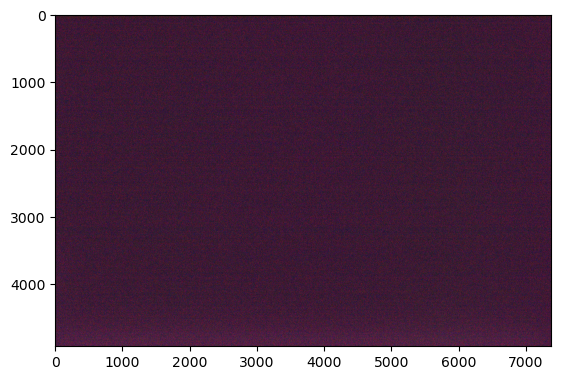

In [9]:
plt.imshow(img)

In [75]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
AUTOTUNE = tf.data.AUTOTUNE

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    shuffle = True,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 162 files belonging to 8 classes.
Using 130 files for training.
Using 32 files for validation.


In [114]:

# List to store the data
data = []

# Iterate over the train_ds dataset and extract the image paths and labels
for images, labels_batch in train_ds:
    for image, label in zip(images, labels_batch):
        # Convert the image tensor to a string
        image_str = tf.strings.format("{}", image)
        
        # Extract the file name
        image_id = tf.strings.split(image_str, os.path.sep)[-1]
        
        # Convert the file name tensor to string
        image_id = tf.strings.reduce_join(image_id).numpy().decode()
        
        # Extract the label
        label_name = train_ds.class_names[label]
        
        # Get the label index
        label_index = label.numpy()
        
        # Add the data to the list
        data.append((image_id, label_name, label_index, "train"))

# Iterate over the val_ds dataset and extract the image paths and labels
for images, labels_batch in val_ds:
    for image, label in zip(images, labels_batch):
        # Convert the image tensor to a string
        image_str = tf.strings.format("{}", image)
        
        # Extract the file name
        image_id = tf.strings.split(image_str, os.path.sep)[-1]
        
        # Convert the file name tensor to string
        image_id = tf.strings.reduce_join(image_id).numpy().decode()
        
        # Extract the label
        label_name = val_ds.class_names[label]
        
        # Get the label index
        label_index = label.numpy()
        
        # Add the data to the list
        data.append((image_id, label_name, label_index, "val"))

# Create the dataframe
df = pd.DataFrame(data, columns=["image_id", "label", "label index", "set"])

# Print the dataframe
print(df)
df.head()

                                              image_id  \
0    [[[4.60546875 5.24414062 5.30078125]\n  [4.365...   
1    [[[125.53125 134.53125 151.53125]\n  [129.5625...   
2    [[[168.501953 176.501953 187.501953]\n  [166.7...   
3    [[[45.3398438 58.3398438 75.4101562]\n  [44.59...   
4    [[[1 1 1]\n  [0.5625 0.5625 0.5625]\n  [1 1 1]...   
..                                                 ...   
157  [[[48.5371094 27.4628906 3.15039062]\n  [49.68...   
158  [[[251 246 250]\n  [251.125 246.125 250.125]\n...   
159  [[[23.1397705 5.85412598 12.1175537]\n  [50.32...   
160  [[[9.765625 10.765625 12.765625]\n  [8.0390625...   
161  [[[123.8125 134.976562 131.500244]\n  [131.000...   

                          label  label index    set  
0             TotalSolarEclipse            7  train  
1                         Flats            5  train  
2              NotASolarEclipse            6  train  
3             TotalSolarEclipse            7  train  
4             TotalSolarEclipse  

,image_id,label,label index,set
0,[[[4.60546875 5.24414062 5.30078125]\n [4.365...,TotalSolarEclipse,7,train
1,[[[125.53125 134.53125 151.53125]\n [129.5625...,Flats,5,train
2,[[[168.501953 176.501953 187.501953]\n [166.7...,NotASolarEclipse,6,train
3,[[[45.3398438 58.3398438 75.4101562]\n [44.59...,TotalSolarEclipse,7,train
4,[[[1 1 1]\n [0.5625 0.5625 0.5625]\n [1 1 1]...,TotalSolarEclipse,7,train


In [120]:
# Count the number of occurrences for each label class in the dataframe
class_counts = df['label'].value_counts()

# Calculate the maximum number of occurrences for any class
max_count = class_counts.max()

# Create an empty dataframe to store the oversampled data
oversampled_data = pd.DataFrame(columns=df.columns)

# Iterate over each label class
for label_class in class_counts.index:
    # Get the data with the current label class
    label_data = df[df['label'] == label_class]
    
    # Calculate the number of samples to resample for the current class
    num_samples = max_count - class_counts[label_class]
    
    # Check if num_samples is 0 and set it to 1
    if num_samples == 0:
        num_samples = 1
    
    # Resample the data for the current class
    resampled_data = resample(label_data, replace=True, n_samples=num_samples, random_state=123)
    
    # Append the resampled data to the oversampled dataframe
    oversampled_data = pd.concat([oversampled_data, resampled_data])
    
# Concatenate the original data with the oversampled data
df_oversampled = pd.concat([df, oversampled_data])

# Print the new dataframe with oversampled data
print(df_oversampled)

                                              image_id              label  \
0    [[[4.60546875 5.24414062 5.30078125]\n  [4.365...  TotalSolarEclipse   
1    [[[125.53125 134.53125 151.53125]\n  [129.5625...              Flats   
2    [[[168.501953 176.501953 187.501953]\n  [166.7...   NotASolarEclipse   
3    [[[45.3398438 58.3398438 75.4101562]\n  [44.59...  TotalSolarEclipse   
4    [[[1 1 1]\n  [0.5625 0.5625 0.5625]\n  [1 1 1]...  TotalSolarEclipse   
..                                                 ...                ...   
142  [[[109.648438 35.625 61.7734375]\n  [120.19531...              Darks   
127  [[[0 0 0]\n  [0.78125 0.78125 0.78125]\n  [1 1...              Darks   
26   [[[42.421875 7.3828125 70.8359375]\n  [55.5546...              Darks   
26   [[[42.421875 7.3828125 70.8359375]\n  [55.5546...              Darks   
127  [[[0 0 0]\n  [0.78125 0.78125 0.78125]\n  [1 1...              Darks   

    label index    set  
0             7  train  
1             5  train  


In [76]:
class_names = train_ds.class_names
print(class_names)

['0to25percentPartialEclipse', '26to55percentPartialEclipse', '56to95percentPartialEclipse', 'Darks', 'DiamondRing_BaileysBeads_SolarEclipse', 'Flats', 'NotASolarEclipse', 'TotalSolarEclipse']


In [77]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [78]:
print(train_ds)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [79]:
#Initialize the normalization layer
normalizer = tf.keras.layers.Normalization(axis=None)

#A Normalization layer should always either be adapted over a dataset or passed mean and variance.
#Adapt it to the training images
#Note: the dataset object contains both the images and the labels (we need to adapt it over the iamges only); 
train_feature_ds = train_ds.map(lambda x, y:x)
normalizer.adapt(train_feature_ds)
val_feature_ds = val_ds.map(lambda x, y:x)
normalizer.adapt(val_feature_ds)

2023-12-07 09:11:49.401664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-07 09:11:49.417431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [80]:
# split data
len(train_ds)

5

In [81]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [82]:
rand_seed = 0

# Create a TF sequential model for data augmentation
data_augmentation = tf.keras.Sequential([
  RandomFlip('horizontal', seed=rand_seed, input_shape=(256, 256, 3)),
  RandomRotation(0.2, seed=rand_seed),
  RandomBrightness(0.2, seed=rand_seed),
  RandomContrast(0.2, seed=rand_seed),
])

In [83]:
# building model
model = Sequential()

In [84]:
# bias imbalance
# class weights

In [85]:

input_shape = (256,256,3)
# Add model layers 
model.add(data_augmentation)
model.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(BatchNormalization()) 
model.add(Conv2D(64, kernel_size=3, activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(BatchNormalization()) 
model.add(Conv2D(128, kernel_size=3, activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(BatchNormalization()) 
model.add(Flatten()) 
model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


In [86]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 128)     0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 127, 127, 128)     512       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      73792     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)       

In [87]:
def compile_model(model):
    """
    This function takes in the model returned from your get_model function, and compiles it with an optimiser,
    loss function and metric.
    Compile the model using the Adam optimiser (with learning rate set to 0.0001), 
    the categorical crossentropy loss function, and accuracy as the only metric. 
    Your function doesn't need to return anything; the model will be compiled in-place.
    """
    
    # YOUR CODE HERE
    # Compile the model 
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])


    return model
    

In [88]:

# Compile model
compile_model(model)

# Define a callback to reduce the learning rate based on the validation accuracy
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            mode = 'max',
                                            factor=0.5,
                                            min_lr=0.00001)

# Define a callback for checkpointing
checkpoint = ModelCheckpoint(filepath='checkpoints_best_only/checkpoint',
                             save_freq='epoch',
                             monitor='val_accuracy',
                             save_weights_only=True,
                             mode='max',
                             save_best_only=True,
                             verbose=0)

# Define a callback for early stopping
EarlyStopping = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

In [89]:
initial_epochs = 50
history = model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds, callbacks=[lr_reduction,checkpoint])


Epoch 1/50


2023-12-07 09:11:58.404902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-07 09:11:58.645379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:11:58.645768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 19s - loss: 4.8879 - accuracy: 0.0312

2023-12-07 09:12:03.043675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:03.043675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 1s - loss: 6.7675 - accuracy: 0.1094 

2023-12-07 09:12:03.395491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:03.395617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 7.4887 - accuracy: 0.1250

2023-12-07 09:12:03.672362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:03.672371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 7.7515 - accuracy: 0.1875

2023-12-07 09:12:03.943889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:03.943891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 7.7099 - accuracy: 0.1846

2023-12-07 09:12:04.306651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 8s 719ms/step - loss: 7.7099 - accuracy: 0.1846 - val_loss: 39.3891 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/50


2023-12-07 09:12:05.614584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:05.614590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 13s - loss: 8.9742 - accuracy: 0.3438

2023-12-07 09:12:09.028130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:09.028202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 9.0625 - accuracy: 0.3438 

2023-12-07 09:12:09.306208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:09.306927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 9.5922 - accuracy: 0.3333

2023-12-07 09:12:09.582441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:09.582446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 10.8194 - accuracy: 0.3000

2023-12-07 09:12:09.856712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:09.856795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 448ms/step - loss: 10.8194 - accuracy: 0.3000 - val_loss: 33.7712 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 3/50


2023-12-07 09:12:10.821445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:10.821465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 13s - loss: 14.5646 - accuracy: 0.3125

2023-12-07 09:12:14.317104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:14.317093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 13.8520 - accuracy: 0.2656 

2023-12-07 09:12:14.584729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:14.584754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 13.0583 - accuracy: 0.2604

2023-12-07 09:12:14.871078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:14.871090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 11.8384 - accuracy: 0.2923

2023-12-07 09:12:15.129661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:15.129691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 6s 502ms/step - loss: 11.8384 - accuracy: 0.2923 - val_loss: 23.9215 - val_accuracy: 0.2812 - lr: 1.0000e-04
Epoch 4/50


2023-12-07 09:12:16.333338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:16.333806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 8.9724 - accuracy: 0.2812

2023-12-07 09:12:19.407304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:19.407830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 8.1411 - accuracy: 0.3281 

2023-12-07 09:12:19.688196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:19.688200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 8.5683 - accuracy: 0.3542

2023-12-07 09:12:19.952483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:19.952483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 8.4649 - accuracy: 0.3594

2023-12-07 09:12:20.213446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:20.213444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 428ms/step - loss: 8.3864 - accuracy: 0.3615 - val_loss: 19.2799 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 5/50


2023-12-07 09:12:21.134729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:21.134746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 14.7133 - accuracy: 0.2812

2023-12-07 09:12:24.374534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:24.374606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 10.6696 - accuracy: 0.3125 

2023-12-07 09:12:24.644540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:24.644568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 9.5753 - accuracy: 0.3438 

2023-12-07 09:12:24.906627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:24.906662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 10.4515 - accuracy: 0.2969

2023-12-07 09:12:25.163332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:25.163329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 416ms/step - loss: 10.3136 - accuracy: 0.3000 - val_loss: 12.9733 - val_accuracy: 0.2812 - lr: 1.0000e-04
Epoch 6/50


2023-12-07 09:12:26.037525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:26.037571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 13s - loss: 11.5790 - accuracy: 0.3438

2023-12-07 09:12:29.438264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:29.439412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 9.1663 - accuracy: 0.3750  

2023-12-07 09:12:29.719800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:29.719897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 10.8386 - accuracy: 0.3854

2023-12-07 09:12:29.987706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:29.987783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 10.6347 - accuracy: 0.3672

2023-12-07 09:12:30.248859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:30.248976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 518ms/step - loss: 10.7242 - accuracy: 0.3692 - val_loss: 13.0599 - val_accuracy: 0.3438 - lr: 1.0000e-04
Epoch 7/50


2023-12-07 09:12:31.538790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:31.538796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 13s - loss: 12.2274 - accuracy: 0.2188

2023-12-07 09:12:34.963197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:34.963211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 9.9722 - accuracy: 0.3281  

2023-12-07 09:12:35.248620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:35.248982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 8.9728 - accuracy: 0.3542

2023-12-07 09:12:35.522280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:35.522281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 9.3842 - accuracy: 0.3672

2023-12-07 09:12:35.781026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:35.781042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 447ms/step - loss: 9.4357 - accuracy: 0.3615 - val_loss: 15.5463 - val_accuracy: 0.3438 - lr: 1.0000e-04
Epoch 8/50


2023-12-07 09:12:36.751327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:36.751407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 13.5094 - accuracy: 0.4062

2023-12-07 09:12:39.927369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:39.927368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 10.4156 - accuracy: 0.4219 

2023-12-07 09:12:40.194028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:40.194201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 9.2921 - accuracy: 0.4271 

2023-12-07 09:12:40.459794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:40.459797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 8.6340 - accuracy: 0.4385

2023-12-07 09:12:40.714101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:40.714104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 421ms/step - loss: 8.6340 - accuracy: 0.4385 - val_loss: 18.2253 - val_accuracy: 0.3125 - lr: 1.0000e-04
Epoch 9/50


2023-12-07 09:12:41.611960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:41.612025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 13s - loss: 9.4663 - accuracy: 0.3750

2023-12-07 09:12:44.867495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:44.867497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 10.1595 - accuracy: 0.3750

2023-12-07 09:12:45.135491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:45.135484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 9.4276 - accuracy: 0.3750 

2023-12-07 09:12:45.397917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:45.397926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 8.5081 - accuracy: 0.4219

2023-12-07 09:12:45.651493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:45.651492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 493ms/step - loss: 8.3867 - accuracy: 0.4231 - val_loss: 18.3414 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 10/50


2023-12-07 09:12:46.842553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:46.842547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 13s - loss: 9.4718 - accuracy: 0.3750

2023-12-07 09:12:50.157049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:50.157529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 9.0912 - accuracy: 0.3750 

2023-12-07 09:12:50.427205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:50.427213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 9.4784 - accuracy: 0.3750

2023-12-07 09:12:50.713175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:50.713176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 8.3342 - accuracy: 0.4308

2023-12-07 09:12:50.975680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:50.975682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 423ms/step - loss: 8.3342 - accuracy: 0.4308 - val_loss: 24.4066 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 11/50


2023-12-07 09:12:51.857666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:51.857746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 15s - loss: 9.5559 - accuracy: 0.3438

2023-12-07 09:12:55.831752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:55.831750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 9.8161 - accuracy: 0.4219 

2023-12-07 09:12:56.118465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:56.118488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 8.9901 - accuracy: 0.4896

2023-12-07 09:12:56.390727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:56.390851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 9.1500 - accuracy: 0.4692

2023-12-07 09:12:56.651348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:56.651372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 6s 455ms/step - loss: 9.1500 - accuracy: 0.4692 - val_loss: 25.4813 - val_accuracy: 0.3438 - lr: 1.0000e-04
Epoch 12/50


2023-12-07 09:12:57.651515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:12:57.651561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 6.0460 - accuracy: 0.4688

2023-12-07 09:13:00.865803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:00.865857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 6.6951 - accuracy: 0.4531 

2023-12-07 09:13:01.128679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:01.128821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 6.8792 - accuracy: 0.4375

2023-12-07 09:13:01.384312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:01.384339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 9.0119 - accuracy: 0.4231

2023-12-07 09:13:01.641689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:01.642049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.



Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
5/5 [==============================] - 5s 419ms/step - loss: 9.0119 - accuracy: 0.4231 - val_loss: 24.2905 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 13/50


2023-12-07 09:13:02.542826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:02.542887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 5.2095 - accuracy: 0.4688

2023-12-07 09:13:05.682637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:05.682820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 6.7835 - accuracy: 0.4531 

2023-12-07 09:13:05.952835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:05.952839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 7.0076 - accuracy: 0.4167

2023-12-07 09:13:06.215527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:06.215529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 6.2914 - accuracy: 0.4538

2023-12-07 09:13:06.474367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:06.474424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 405ms/step - loss: 6.2914 - accuracy: 0.4538 - val_loss: 20.1341 - val_accuracy: 0.3750 - lr: 5.0000e-05
Epoch 14/50


2023-12-07 09:13:07.302679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:07.302699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 13s - loss: 6.4489 - accuracy: 0.4375

2023-12-07 09:13:10.571055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:10.571182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 7.4136 - accuracy: 0.4375 

2023-12-07 09:13:10.849092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:10.849403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 6.3387 - accuracy: 0.4896

2023-12-07 09:13:11.117421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:11.117421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 6.7659 - accuracy: 0.4375

2023-12-07 09:13:11.383590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:11.383715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 504ms/step - loss: 6.6618 - accuracy: 0.4462 - val_loss: 14.9809 - val_accuracy: 0.4375 - lr: 5.0000e-05
Epoch 15/50


2023-12-07 09:13:12.589577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:12.589625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 6.0386 - accuracy: 0.4688

2023-12-07 09:13:15.820463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:15.820495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 7.3931 - accuracy: 0.4531 

2023-12-07 09:13:16.094807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:16.094945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 7.5808 - accuracy: 0.4688

2023-12-07 09:13:16.363393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:16.364054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 7.3972 - accuracy: 0.4769

2023-12-07 09:13:16.625405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:16.625493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 560ms/step - loss: 7.3972 - accuracy: 0.4769 - val_loss: 13.2151 - val_accuracy: 0.4688 - lr: 5.0000e-05
Epoch 16/50


2023-12-07 09:13:18.067793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:18.067794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 13s - loss: 6.3611 - accuracy: 0.4375

2023-12-07 09:13:21.442484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:21.442942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 6.1991 - accuracy: 0.5469 

2023-12-07 09:13:21.713000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:21.713259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 6.2874 - accuracy: 0.5417

2023-12-07 09:13:21.983176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:21.983168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 6.5493 - accuracy: 0.5538

2023-12-07 09:13:22.246969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:22.247045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 503ms/step - loss: 6.5493 - accuracy: 0.5538 - val_loss: 11.7458 - val_accuracy: 0.5000 - lr: 5.0000e-05
Epoch 17/50


2023-12-07 09:13:23.455684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:23.455708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 3.5095 - accuracy: 0.6250

2023-12-07 09:13:26.667419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:26.667665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 4.9840 - accuracy: 0.5156 

2023-12-07 09:13:26.930583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:26.930942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 6.1332 - accuracy: 0.4896

2023-12-07 09:13:27.191900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:27.191896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 6.4242 - accuracy: 0.5000

2023-12-07 09:13:27.448080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:27.448158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 400ms/step - loss: 6.5197 - accuracy: 0.5000 - val_loss: 11.6579 - val_accuracy: 0.4688 - lr: 5.0000e-05
Epoch 18/50


2023-12-07 09:13:28.270375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:28.270400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 6.9870 - accuracy: 0.4688

2023-12-07 09:13:31.426107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:31.427024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 7.1378 - accuracy: 0.5000 

2023-12-07 09:13:31.682281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:31.682982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 7.1222 - accuracy: 0.4896

2023-12-07 09:13:31.941688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:31.941689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 7.2517 - accuracy: 0.4766

2023-12-07 09:13:32.202845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:32.202858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 416ms/step - loss: 7.3552 - accuracy: 0.4769 - val_loss: 12.9669 - val_accuracy: 0.4688 - lr: 5.0000e-05
Epoch 19/50


2023-12-07 09:13:33.091026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:33.091044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 5.6743 - accuracy: 0.6250

2023-12-07 09:13:36.304268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:36.304275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 6.1315 - accuracy: 0.5469 

2023-12-07 09:13:36.569758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:36.569760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 7.7002 - accuracy: 0.5104

2023-12-07 09:13:36.825163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:36.825174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 7.2689 - accuracy: 0.5078

2023-12-07 09:13:37.084529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:37.084647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.



Epoch 19: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
5/5 [==============================] - 5s 429ms/step - loss: 7.2501 - accuracy: 0.5000 - val_loss: 12.8172 - val_accuracy: 0.5000 - lr: 5.0000e-05
Epoch 20/50


2023-12-07 09:13:38.026022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:38.026041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 13s - loss: 6.0560 - accuracy: 0.5000

2023-12-07 09:13:41.302561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:41.302781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 5.9821 - accuracy: 0.4844 

2023-12-07 09:13:41.563788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:41.563878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 5.8939 - accuracy: 0.5000

2023-12-07 09:13:41.828369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:41.828440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 5.9450 - accuracy: 0.4766

2023-12-07 09:13:42.084455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:42.084457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 403ms/step - loss: 5.8535 - accuracy: 0.4846 - val_loss: 12.6559 - val_accuracy: 0.4688 - lr: 2.5000e-05
Epoch 21/50


2023-12-07 09:13:42.916780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:42.916822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 5.1722 - accuracy: 0.5000

2023-12-07 09:13:46.099291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:46.099458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 6.5301 - accuracy: 0.4844 

2023-12-07 09:13:46.361936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:46.361946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 5.9794 - accuracy: 0.5312

2023-12-07 09:13:46.619077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:46.619267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 7.3568 - accuracy: 0.5078

2023-12-07 09:13:46.875294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:46.875298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 402ms/step - loss: 7.3003 - accuracy: 0.5077 - val_loss: 12.8680 - val_accuracy: 0.4688 - lr: 2.5000e-05
Epoch 22/50


2023-12-07 09:13:47.709662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:47.709683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 13s - loss: 5.3339 - accuracy: 0.5312

2023-12-07 09:13:50.971236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:50.971679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 5.6370 - accuracy: 0.5156 

2023-12-07 09:13:51.241154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:51.241398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 6.5986 - accuracy: 0.5312

2023-12-07 09:13:51.500612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:51.500603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 6.5106 - accuracy: 0.5462

2023-12-07 09:13:51.758403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:51.758479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.



Epoch 22: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
5/5 [==============================] - 5s 497ms/step - loss: 6.5106 - accuracy: 0.5462 - val_loss: 13.1993 - val_accuracy: 0.4688 - lr: 2.5000e-05
Epoch 23/50


2023-12-07 09:13:52.972406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:52.972762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 15s - loss: 6.5881 - accuracy: 0.5000

2023-12-07 09:13:56.751135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:56.751910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 5.8700 - accuracy: 0.4844 

2023-12-07 09:13:57.059547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:57.059535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 5.4042 - accuracy: 0.5312

2023-12-07 09:13:57.353579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:57.353594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 5.2635 - accuracy: 0.4923

2023-12-07 09:13:57.611402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:57.611739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 6s 457ms/step - loss: 5.2635 - accuracy: 0.4923 - val_loss: 13.0156 - val_accuracy: 0.4688 - lr: 1.2500e-05
Epoch 24/50


2023-12-07 09:13:58.551557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:13:58.551654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 7.9529 - accuracy: 0.4375

2023-12-07 09:14:01.772999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:01.773205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 8.5917 - accuracy: 0.4844 

2023-12-07 09:14:02.035157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:02.035399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 7.9190 - accuracy: 0.5000

2023-12-07 09:14:02.294380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:02.294381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 7.9668 - accuracy: 0.4922

2023-12-07 09:14:02.551629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:02.551697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 404ms/step - loss: 7.9997 - accuracy: 0.4846 - val_loss: 12.6068 - val_accuracy: 0.4688 - lr: 1.2500e-05
Epoch 25/50


2023-12-07 09:14:03.390229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:03.390236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 13s - loss: 9.9209 - accuracy: 0.5000

2023-12-07 09:14:06.656719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:06.656774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 8.5115 - accuracy: 0.5156 

2023-12-07 09:14:06.918983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:06.919326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 7.2578 - accuracy: 0.5208

2023-12-07 09:14:07.183629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:07.183629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 6.8048 - accuracy: 0.5469

2023-12-07 09:14:07.440155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:07.440185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.



Epoch 25: ReduceLROnPlateau reducing learning rate to 1e-05.
5/5 [==============================] - 5s 420ms/step - loss: 6.7001 - accuracy: 0.5538 - val_loss: 12.0083 - val_accuracy: 0.5000 - lr: 1.2500e-05
Epoch 26/50


2023-12-07 09:14:08.335937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:08.335942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 13s - loss: 8.5624 - accuracy: 0.5312

2023-12-07 09:14:11.592571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:11.592571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 6.0208 - accuracy: 0.5938 

2023-12-07 09:14:11.851289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:11.851299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 7.5746 - accuracy: 0.5521

2023-12-07 09:14:12.110146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:12.110227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 6.8873 - accuracy: 0.5692

2023-12-07 09:14:12.371551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:12.371579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 412ms/step - loss: 6.8873 - accuracy: 0.5692 - val_loss: 11.6630 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 27/50


2023-12-07 09:14:13.239513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:13.239614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 10.0788 - accuracy: 0.4062

2023-12-07 09:14:16.406952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:16.407077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 6.5676 - accuracy: 0.5000  

2023-12-07 09:14:16.663458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:16.663624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 6.0148 - accuracy: 0.5312

2023-12-07 09:14:16.920992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:16.920989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 6.1255 - accuracy: 0.5156

2023-12-07 09:14:17.175772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:17.175775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 394ms/step - loss: 6.1242 - accuracy: 0.5154 - val_loss: 11.5674 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 28/50


2023-12-07 09:14:17.986427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:17.986427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 3.6704 - accuracy: 0.6562

2023-12-07 09:14:21.120200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:21.120219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 4.7380 - accuracy: 0.5625 

2023-12-07 09:14:21.384617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:21.384894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 4.8659 - accuracy: 0.5104

2023-12-07 09:14:21.654372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:21.654374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 5.5549 - accuracy: 0.5234

2023-12-07 09:14:21.912076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:21.912159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 405ms/step - loss: 5.5597 - accuracy: 0.5231 - val_loss: 11.3948 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 29/50


2023-12-07 09:14:22.739073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:22.739103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 7.5577 - accuracy: 0.5000

2023-12-07 09:14:25.883483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:25.884806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 6.2227 - accuracy: 0.5156 

2023-12-07 09:14:26.144389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:26.144501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 6.1872 - accuracy: 0.5104

2023-12-07 09:14:26.402906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:26.402934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 6.0318 - accuracy: 0.5234

2023-12-07 09:14:26.661503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:26.661554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 402ms/step - loss: 6.0426 - accuracy: 0.5231 - val_loss: 11.2991 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 30/50


2023-12-07 09:14:27.492073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:27.492093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 7.5667 - accuracy: 0.4688

2023-12-07 09:14:30.686694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:30.686703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 5.6444 - accuracy: 0.5938 

2023-12-07 09:14:30.959941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:30.959942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 5.3718 - accuracy: 0.5938

2023-12-07 09:14:31.216768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:31.216776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 5.0624 - accuracy: 0.6094

2023-12-07 09:14:31.466115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:31.466125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 484ms/step - loss: 5.1086 - accuracy: 0.6077 - val_loss: 11.0202 - val_accuracy: 0.5312 - lr: 1.0000e-05
Epoch 31/50


2023-12-07 09:14:32.639488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:32.639516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 4.4792 - accuracy: 0.5625

2023-12-07 09:14:35.856557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:35.856603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 4.5835 - accuracy: 0.6250 

2023-12-07 09:14:36.118564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:36.118524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 5.6301 - accuracy: 0.5625

2023-12-07 09:14:36.384148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:36.384150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 6.7980 - accuracy: 0.5078

2023-12-07 09:14:36.643166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:36.643180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 407ms/step - loss: 6.6934 - accuracy: 0.5154 - val_loss: 10.9104 - val_accuracy: 0.5312 - lr: 1.0000e-05
Epoch 32/50


2023-12-07 09:14:37.484432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:37.484542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 13s - loss: 7.0287 - accuracy: 0.5000

2023-12-07 09:14:40.902812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:40.903028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 6.6980 - accuracy: 0.5156 

2023-12-07 09:14:41.185608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:41.185910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 6.3606 - accuracy: 0.5104

2023-12-07 09:14:41.464853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:41.464867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 5.9559 - accuracy: 0.5462

2023-12-07 09:14:41.724262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:41.724266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 459ms/step - loss: 5.9559 - accuracy: 0.5462 - val_loss: 10.9072 - val_accuracy: 0.5312 - lr: 1.0000e-05
Epoch 33/50


2023-12-07 09:14:42.742362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:42.742364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 4.1041 - accuracy: 0.6250

2023-12-07 09:14:45.904605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:45.904668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 4.0962 - accuracy: 0.6250 

2023-12-07 09:14:46.176717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:46.176734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 5.5244 - accuracy: 0.5521

2023-12-07 09:14:46.435501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:46.435501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 5.4757 - accuracy: 0.5469

2023-12-07 09:14:46.696796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:46.696817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 406ms/step - loss: 5.4358 - accuracy: 0.5462 - val_loss: 10.8791 - val_accuracy: 0.5312 - lr: 1.0000e-05
Epoch 34/50


2023-12-07 09:14:47.527716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:47.527725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 13s - loss: 6.5629 - accuracy: 0.4375

2023-12-07 09:14:50.784764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:50.784846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 6.1968 - accuracy: 0.4531 

2023-12-07 09:14:51.049229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:51.049304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 5.9650 - accuracy: 0.4896

2023-12-07 09:14:51.305878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:51.305868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 5.6185 - accuracy: 0.5077

2023-12-07 09:14:51.567606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:51.567608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 487ms/step - loss: 5.6185 - accuracy: 0.5077 - val_loss: 10.8743 - val_accuracy: 0.5312 - lr: 1.0000e-05
Epoch 35/50


2023-12-07 09:14:52.737244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:52.737282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 14s - loss: 4.8693 - accuracy: 0.6250

2023-12-07 09:14:56.287690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:56.288134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 6.2682 - accuracy: 0.5000 

2023-12-07 09:14:56.593007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:56.592868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 5.4427 - accuracy: 0.5417

2023-12-07 09:14:56.883359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:56.883503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 5.1689 - accuracy: 0.5538

2023-12-07 09:14:57.151561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:57.151645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 457ms/step - loss: 5.1689 - accuracy: 0.5538 - val_loss: 10.8070 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 36/50


2023-12-07 09:14:58.117815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:14:58.117815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 5.7387 - accuracy: 0.4688

2023-12-07 09:15:01.282053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:01.282052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 6.5221 - accuracy: 0.4219 

2023-12-07 09:15:01.542377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:01.543026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 5.8131 - accuracy: 0.4896

2023-12-07 09:15:01.810229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:01.810242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 5.9538 - accuracy: 0.5234

2023-12-07 09:15:02.071276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:02.071426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 419ms/step - loss: 5.8624 - accuracy: 0.5308 - val_loss: 10.5394 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 37/50


2023-12-07 09:15:02.958589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:02.958591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 11.0137 - accuracy: 0.5312

2023-12-07 09:15:06.117715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:06.117999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 7.5669 - accuracy: 0.5625  

2023-12-07 09:15:06.383728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:06.383756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 8.2461 - accuracy: 0.5729

2023-12-07 09:15:06.635705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:06.635709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 7.1886 - accuracy: 0.5859

2023-12-07 09:15:06.896772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:06.896772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 407ms/step - loss: 7.4543 - accuracy: 0.5769 - val_loss: 10.4253 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 38/50


2023-12-07 09:15:07.746392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:07.746390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 13s - loss: 4.5949 - accuracy: 0.5625

2023-12-07 09:15:11.031463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:11.031459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 5.0318 - accuracy: 0.5156 

2023-12-07 09:15:11.307982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:11.308108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 6.4810 - accuracy: 0.4688

2023-12-07 09:15:11.568409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:11.568429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 6.7886 - accuracy: 0.4769

2023-12-07 09:15:11.827695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:11.827698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 424ms/step - loss: 6.7886 - accuracy: 0.4769 - val_loss: 10.4367 - val_accuracy: 0.5312 - lr: 1.0000e-05
Epoch 39/50


2023-12-07 09:15:12.726678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:12.726757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 9.7536 - accuracy: 0.4062

2023-12-07 09:15:15.913845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:15.913980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 7.5323 - accuracy: 0.5000 

2023-12-07 09:15:16.185179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:16.186249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 6.2514 - accuracy: 0.5312

2023-12-07 09:15:16.459387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:16.459488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 5.8829 - accuracy: 0.5692

2023-12-07 09:15:16.721084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:16.721084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 411ms/step - loss: 5.8829 - accuracy: 0.5692 - val_loss: 10.4951 - val_accuracy: 0.5312 - lr: 1.0000e-05
Epoch 40/50


2023-12-07 09:15:17.553467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:17.553476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 3.4972 - accuracy: 0.6562

2023-12-07 09:15:20.671852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:20.672820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 5.8251 - accuracy: 0.5312 

2023-12-07 09:15:20.952411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:20.952448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 5.4643 - accuracy: 0.5208

2023-12-07 09:15:21.217278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:21.217301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 5.9959 - accuracy: 0.5156

2023-12-07 09:15:21.475195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:21.475214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 488ms/step - loss: 5.9443 - accuracy: 0.5077 - val_loss: 10.4201 - val_accuracy: 0.5625 - lr: 1.0000e-05
Epoch 41/50


2023-12-07 09:15:22.636750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:22.636783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 6.6430 - accuracy: 0.4688

2023-12-07 09:15:25.813003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:25.813045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 5.7035 - accuracy: 0.5156 

2023-12-07 09:15:26.074849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:26.074903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 6.3628 - accuracy: 0.4792

2023-12-07 09:15:26.333156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:26.333156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 6.3065 - accuracy: 0.4922

2023-12-07 09:15:26.587874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:26.589200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 397ms/step - loss: 6.2095 - accuracy: 0.5000 - val_loss: 10.4210 - val_accuracy: 0.5312 - lr: 1.0000e-05
Epoch 42/50


2023-12-07 09:15:27.401217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:27.401300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 5.1936 - accuracy: 0.5312

2023-12-07 09:15:30.537418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:30.537421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 5.2850 - accuracy: 0.5938 

2023-12-07 09:15:30.803105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:30.803121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 5.8031 - accuracy: 0.5729

2023-12-07 09:15:31.064581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:31.064588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 6.1178 - accuracy: 0.5625

2023-12-07 09:15:31.318615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:31.318642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 401ms/step - loss: 6.1749 - accuracy: 0.5538 - val_loss: 10.4994 - val_accuracy: 0.5312 - lr: 1.0000e-05
Epoch 43/50


2023-12-07 09:15:32.138765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:32.138767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 5.8860 - accuracy: 0.5938

2023-12-07 09:15:35.232797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:35.233186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 7.3152 - accuracy: 0.5312 

2023-12-07 09:15:35.497644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:35.497651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 6.4623 - accuracy: 0.5521

2023-12-07 09:15:35.758996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:35.759075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 6.7302 - accuracy: 0.5234

2023-12-07 09:15:36.019837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:36.019897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 405ms/step - loss: 6.7136 - accuracy: 0.5231 - val_loss: 10.5345 - val_accuracy: 0.5312 - lr: 1.0000e-05
Epoch 44/50


2023-12-07 09:15:36.853440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:36.853504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 3.9595 - accuracy: 0.6562

2023-12-07 09:15:39.947447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:39.947970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 4.7552 - accuracy: 0.5781 

2023-12-07 09:15:40.217614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:40.217624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 4.2691 - accuracy: 0.6146

2023-12-07 09:15:40.473685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:40.473814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 4.3386 - accuracy: 0.6094

2023-12-07 09:15:40.734208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:40.734278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 395ms/step - loss: 4.2857 - accuracy: 0.6077 - val_loss: 10.6885 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 45/50


2023-12-07 09:15:41.525620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:41.525619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 7.7626 - accuracy: 0.5000

2023-12-07 09:15:44.771045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:44.771051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 7.2468 - accuracy: 0.4844 

2023-12-07 09:15:45.041608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:45.041608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 6.9335 - accuracy: 0.5312

2023-12-07 09:15:45.300711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:45.300708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 6.7762 - accuracy: 0.5231

2023-12-07 09:15:45.555585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:45.555654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 408ms/step - loss: 6.7762 - accuracy: 0.5231 - val_loss: 10.6838 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 46/50


2023-12-07 09:15:46.403695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:46.403702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 6.7742 - accuracy: 0.4375

2023-12-07 09:15:49.569197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:49.569484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 5.6755 - accuracy: 0.5000 

2023-12-07 09:15:49.846515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:49.846526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 6.0300 - accuracy: 0.5104

2023-12-07 09:15:50.113752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:50.113756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 6.1394 - accuracy: 0.4923

2023-12-07 09:15:50.382590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:50.382602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 422ms/step - loss: 6.1394 - accuracy: 0.4923 - val_loss: 10.7611 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 47/50


2023-12-07 09:15:51.255921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:51.255929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 15s - loss: 5.6878 - accuracy: 0.5312

2023-12-07 09:15:55.060455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:55.061060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 5.8756 - accuracy: 0.5000 

2023-12-07 09:15:55.330299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:55.330327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 6.1898 - accuracy: 0.5104

2023-12-07 09:15:55.596500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:55.596613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - ETA: 0s - loss: 6.1666 - accuracy: 0.5231

2023-12-07 09:15:55.859184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:55.859456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 6s 473ms/step - loss: 6.1666 - accuracy: 0.5231 - val_loss: 10.8841 - val_accuracy: 0.5625 - lr: 1.0000e-05
Epoch 48/50


2023-12-07 09:15:56.968751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:15:56.968781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 7.7909 - accuracy: 0.2812

2023-12-07 09:16:00.191697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:16:00.191896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 6.4412 - accuracy: 0.4531 

2023-12-07 09:16:00.453915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:16:00.454050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 6.3968 - accuracy: 0.5104

2023-12-07 09:16:00.714122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:16:00.714151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 6.5444 - accuracy: 0.5078

2023-12-07 09:16:00.970747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:16:00.970758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 406ms/step - loss: 6.5699 - accuracy: 0.5000 - val_loss: 10.9719 - val_accuracy: 0.5312 - lr: 1.0000e-05
Epoch 49/50


2023-12-07 09:16:01.815502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:16:01.815510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 3.6689 - accuracy: 0.6875

2023-12-07 09:16:04.977152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:16:04.977533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 4.6513 - accuracy: 0.5938 

2023-12-07 09:16:05.243133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:16:05.243539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 4.9976 - accuracy: 0.5625

2023-12-07 09:16:05.507328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:16:05.507503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 5.2083 - accuracy: 0.5703

2023-12-07 09:16:05.764450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:16:05.764455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 399ms/step - loss: 5.6715 - accuracy: 0.5615 - val_loss: 11.2116 - val_accuracy: 0.5312 - lr: 1.0000e-05
Epoch 50/50


2023-12-07 09:16:06.573121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:16:06.573119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/5 [=====>........................] - ETA: 12s - loss: 4.3710 - accuracy: 0.5625

2023-12-07 09:16:09.718875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:16:09.718881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/5 [===========>..................] - ETA: 0s - loss: 4.6875 - accuracy: 0.5625 

2023-12-07 09:16:09.986267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:16:09.986276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/5 [=================>............] - ETA: 0s - loss: 5.5943 - accuracy: 0.5000

2023-12-07 09:16:10.250970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:16:10.250975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/5 [=======================>......] - ETA: 0s - loss: 5.5012 - accuracy: 0.4766

2023-12-07 09:16:10.506370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-07 09:16:10.506461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/5 [==============================] - 5s 413ms/step - loss: 5.6556 - accuracy: 0.4692 - val_loss: 11.3535 - val_accuracy: 0.5312 - lr: 1.0000e-05


In [ ]:
# Print a summary of the training accuracy and loss
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
# SPRINT 2
# Fix issue with cr2 and nef file types not being loaded
# Implement solutions to overfitting (regularization, preprocessing tactics, data augmentation)